In [1]:
import cv2
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os

/home/sg24duk/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Maximum Entropy Among the Input Sequnce: 5.2476015838836245
Medium Luminance Among the Input Sequence: 73.8907997979058,corresponds to image18 mid-exposed.
Skipping invalid image: onemore
Skipping invalid image: result
Global Luminance for chosen Reference Img: 73.87924194335938


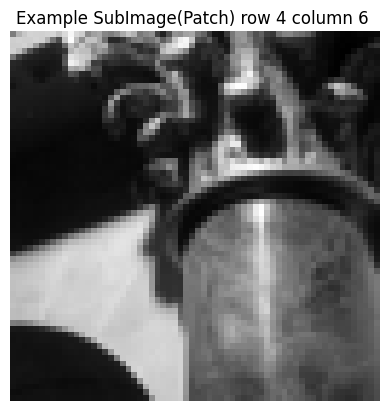

In [2]:
folder_path = '/home/sg24duk/dataset/scene3'
ref_img_path = '/home/sg24duk/dataset/scene3/18.png' 

def calculate_entropy(frame):
    hist, _ = np.histogram(frame.flatten(), bins=256, range=(0, 256), density=True)
    image_entropy = entropy(hist)
    return image_entropy

def cal_cum_entropy(my_list,image,sub_height,sub_width):
    cumulative_entropy = 0
    for i in range(len(my_list)): 
        x,y = my_list[i]
        sub_image_section = image[x * sub_height:(x + 1) * sub_height, y * sub_width:(y + 1) * sub_width]
        entropyval = calculate_entropy(sub_image_section)
        ##print(f"calc entropy;{entropyval}")
        cumulative_entropy += entropyval
    
    return cumulative_entropy/len(my_list)


entropy_values_full_img = []
mean_luminance_values = []
mean_lum_mean =0
max_entropy = -float('inf') 

for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        continue  # Skip non-image files
    
    img_entropy = calculate_entropy(img)
    img_global_lum = np.mean(img)
    entropy_values_full_img.append((filename, img_entropy))
    mean_luminance_values.append((filename,img_global_lum))
    mean_lum_mean += img_global_lum
    # Track the maximum entropy
    if img_entropy > max_entropy:
        max_entropy = img_entropy

mean_lum_mean = mean_lum_mean/30


# Print the maximum entropy
print(f"Maximum Entropy Among the Input Sequnce: {max_entropy}")

print(f"Medium Luminance Among the Input Sequence: {mean_lum_mean},corresponds to image18 mid-exposed.")

img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)

heigt,width = img.shape

glMu = np.mean(img)

height_scaler = 6
width_scaler = 8

sub_height = heigt // height_scaler
sub_width = width // width_scaler

sub_image = np.zeros((sub_height, sub_width, height_scaler, width_scaler))
sub_luminance = []
over_exp = []
under_exp =  []
over_exp_width = []
over_exp_length = []
under_exp_width = []
under_exp_length = []

for i in range(height_scaler):
    for j in range(width_scaler):

        sub_image_section = img[i * sub_height:(i + 1) * sub_height, j * sub_width:(j + 1) * sub_width]
        
        sub_image[:,:,i,j] = sub_image_section

        sub_luminance_cal = np.mean(sub_image_section)
        sub_luminance.append(sub_luminance_cal)

        if(sub_luminance_cal >= glMu*2):
            over_exp.append((i,j))
            ##over_exp_width.append(i * sub_height:(i + 1) * sub_height)
            ##over_exp_length.append(j * sub_width:(j + 1) * sub_width)
        if(sub_luminance_cal <= glMu*0.5):
            under_exp.append((i,j))
            ##under_exp_width 
            ##under_exp_length


under_exp_entropy = []
over_exp_entropy = []
file_order = []

for idx, filename in enumerate(sorted(os.listdir(folder_path))):

    image_path = os.path.join(folder_path, filename)

    ##print(filename)
    
    # Read the image in grayscale
    img2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img2 is None:
        print(f"Skipping invalid image: {filename}")
        continue  # Skip invalid files
    over_exp_entropy_val = cal_cum_entropy(over_exp,img2,sub_height,sub_width)
    under_exp_entropy_val = cal_cum_entropy(under_exp,img2,sub_height,sub_width)
    
    file_order.append(filename)
    over_exp_entropy.append(over_exp_entropy_val)
    under_exp_entropy.append( under_exp_entropy_val)




# Print results
print(f"Global Luminance for chosen Reference Img: {glMu}")

## print example patch 
plt.imshow(sub_image[:,:,3,5],cmap="gray")
plt.title("Example SubImage(Patch) row 4 column 6 ")
plt.axis('off')  # Turn off axis labels
plt.show()





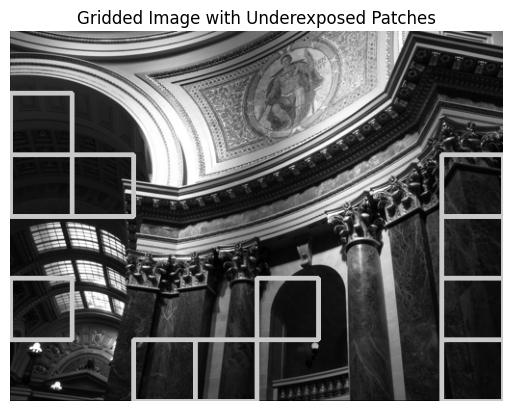

In [3]:

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for patch in under_exp:
    i, j = patch  # Unpack the indices of the underexposed patch

    # Calculate the top-left and bottom-right coordinates of the patch
    top_left = (j * sub_width, i * sub_height)
    bottom_right = ((j + 1) * sub_width, (i + 1) * sub_height)

    # Draw the rectangle for the underexposed patch (red color)
    cv2.rectangle(img, top_left, bottom_right, (200), 3)  # Red rectangle with thickness of 3
    
img_rgb_with_rectangles = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Show the image with rectangles on top
ax.imshow(img, cmap='gray')
ax.set_title('Gridded Image with Underexposed Patches')
ax.axis('off')  # Hide axes
plt.show()

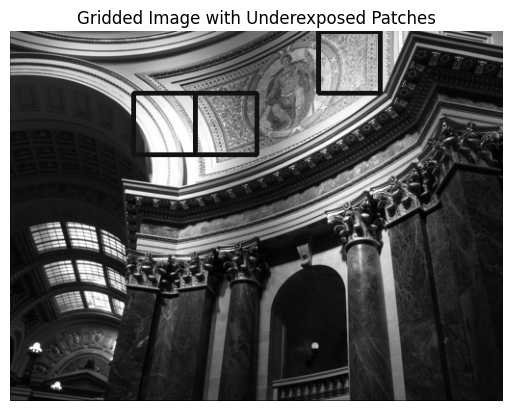

In [4]:
img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
for patch in over_exp:
    i, j = patch  # Unpack the indices of the underexposed patch

    # Calculate the top-left and bottom-right coordinates of the patch
    top_left = (j * sub_width, i * sub_height)
    bottom_right = ((j + 1) * sub_width, (i + 1) * sub_height)

    # Draw the rectangle for the underexposed patch (red color)
    cv2.rectangle(img, top_left, bottom_right, (20), 3)  # Red rectangle with thickness of 3
    
img_rgb_with_rectangles = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Show the image with rectangles on top
ax.imshow(img, cmap='gray')
ax.set_title('Gridded Image with Underexposed Patches')
ax.axis('off')  # Hide axes
plt.show()

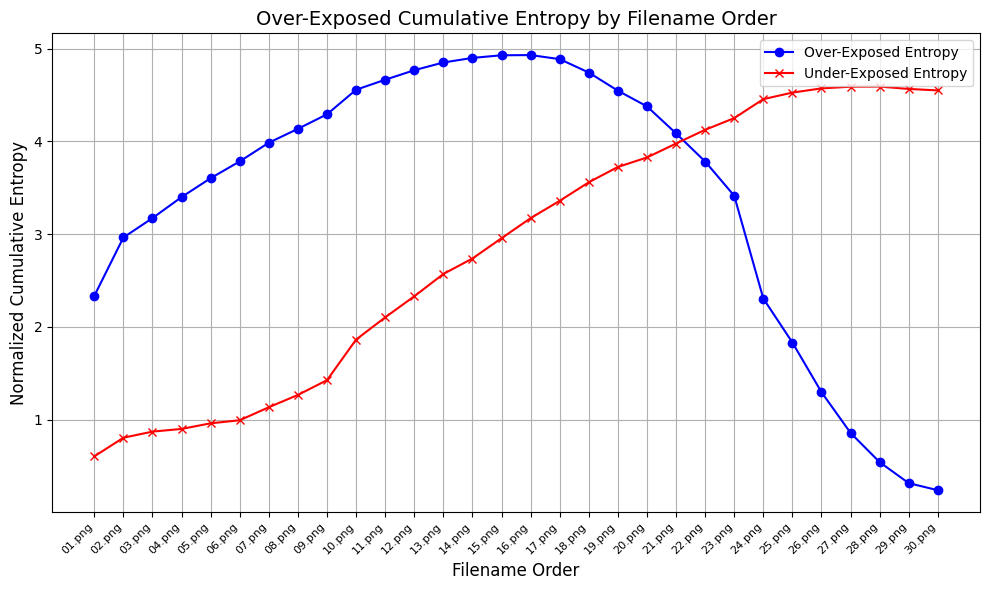

In [5]:

plt.figure(figsize=(10, 6))
plt.plot(file_order, over_exp_entropy, marker='o', linestyle='-', color='blue', label='Over-Exposed Entropy')
plt.plot(file_order, under_exp_entropy, marker='x', linestyle='-', color='red', label='Under-Exposed Entropy')
plt.xlabel('Filename Order', fontsize=12)
plt.ylabel('Normalized Cumulative Entropy', fontsize=12)
plt.title('Over-Exposed Cumulative Entropy by Filename Order', fontsize=14)
plt.xticks(rotation=45, fontsize=8, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to avoid clipping
plt.legend()
plt.grid()
plt.show()

In [6]:
## image 27 is the best for undexposed
## image 15 is the best for overexposed
## image 18 is the reference for being medium exposed. 


img27 = cv2.imread(os.path.join(folder_path,"27.png"), cv2.IMREAD_GRAYSCALE)
entropy27 = calculate_entropy(img27)

img15 = cv2.imread(os.path.join(folder_path,"15.png"), cv2.IMREAD_GRAYSCALE)
entropy15 = calculate_entropy(img15)

img18 = cv2.imread(os.path.join(folder_path,"18.png"), cv2.IMREAD_GRAYSCALE)
entropy18 = calculate_entropy(img18)

img_result = cv2.imread("14Output_20250118_225051.png", cv2.IMREAD_GRAYSCALE)
entropy_result = calculate_entropy(img_result)

print(f" entropy of ref img:{entropy18}\n entropy of img27:{entropy27} \n entropy of img15:{entropy15}\n Maximum entropy in the dataset: {max_entropy},\n fused entropy: {entropy_result}")

 entropy of ref img:5.077483844445711
 entropy of img27:4.660779000709989 
 entropy of img15:4.6901447531243905
 Maximum entropy in the dataset: 5.2476015838836245,
 fused entropy: 5.395836579656334


In [7]:
######### SSIM ##########
ssim_val , _ = ssim(img18,img_result, full=True)
print(f"SSIM index between reference and fused image {ssim_val}")

SSIM index between reference and fused image 0.6685993019731931


What IF I HAD choosen other two images without considering their entropy merits.

In [8]:
img_result = cv2.imread("14Output_20250118_230758.png", cv2.IMREAD_GRAYSCALE)  ## Fused img with ref= 18, 08 and 09.
entropy_result = calculate_entropy(img_result)
print(entropy_result)

4.962232939071841


In [9]:
# Load reference and distorted images
reference_image = cv2.imread('/home/sg24duk/dataset/scene2/2.png', cv2.IMREAD_GRAYSCALE)
distorted_image = cv2.imread('14Output_20250118_164002.png', cv2.IMREAD_GRAYSCALE)

# Calculate PSNR
psnr_value = cv2.PSNR(reference_image, distorted_image)
print(f"PSNR: {psnr_value} dB")


PSNR: 19.174281364570383 dB
